# BEM114 Homework 2 - Statistical Arbitrage
**Names:** Andrew Zabelo, Daniel Wen, Kyle McCandless  
**Student IDs:** 2176083, 2159859, 2157818

## Setup
Imports, Helper Functions, and DataFrames

In [1]:
'''
Imports
'''

import pandas as pd
import numpy as np
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [2]:
'''
Helper functions
'''

# Given a group of stocks, calculate equal-weighted and value-weighted weights
def calc_weights(group):
    # Calc equal weights
    group['weights_eq'] = 1 / float(group['decile'].count())
    # Calc total market equity of group
    group['TMV'] = group['MV'].sum()
    # Calc value weights
    group['weights_val'] = group['MV'] / group['TMV']
    return group

# Part b of problems 2,3,4: Calculates monthly returns from monthly weights
def part_b(df):
    # Calculate weights times returns
    df['weighted_val_ret'] = df['weights_val_lag'] * df['RET']
    df['weighted_eq_ret'] = df['weights_eq_lag'] * df['RET']

    # Sum up portfolio returns
    eqports = df.groupby(['date', 'decile_lag'])['weighted_eq_ret'].sum()
    eqports = eqports.unstack()
    
    # Drop if missing accounting data in early years
    eqports = eqports.dropna(axis=0)
    
    # Match data format of FF factors
    eqports = eqports * 100
    eqports = eqports.reset_index()

    valports = df.groupby(['date', 'decile_lag'])['weighted_val_ret'].sum()
    valports = valports.unstack()
    valports = valports.dropna(axis=0)
    valports = valports * 100
    valports = valports.reset_index()
    
    return eqports, valports

# Creates a graph of the decile mean returns
def graph_deciles(df, title):
    df_mean = df.mean(numeric_only=True)
    df_mean.plot(kind='bar', x='Decile Portfolio', y='values', legend=False)
    plt.xlabel('Decile Portfolio')
    plt.ylabel('Mean Monthly Returns')
    plt.title(title)
    plt.show()

# Calculates returns and prints the returns mean, vol, and Sharpe ratio for a strategy
def analyze(df, strat_name, ret_col_name, reverse=False):
    df[ret_col_name] = df[10.0] - df[1.0] if reverse else df[1.0] - df[10.0] 
    
    strat_mean = df[ret_col_name].mean()
    strat_vol = df[ret_col_name].std()
    strat_sharpe = strat_mean / strat_vol

    print(f"{strat_name} monthly returns have mean {strat_mean}, vol {strat_vol}, and Sharpe {strat_sharpe}")

# Estimates the CAPM and FF3 models on df_old using the returns found in ret_col_name
def estimate_capm_and_ff3(df_old, ret_col_name, ff3):
    # Merge in ff3 data. Keep separate from ff5 because there is a larger data range available in ff3.
    # May lose a few rows since ff3 goes back to July 1926 and our data starts Jan 1926
    df = pd.merge(df_old, ff3, how='inner', on=['date'])
    
    # Estimate CAPM
    print('CAPM')
    print(sm.OLS(df[ret_col_name] - df['RF'], sm.add_constant(df[['Mkt-RF']])).fit().summary())
    
    # Estimate FF3
    print('FF3')
    print(sm.OLS(df[ret_col_name] - df['RF'], sm.add_constant(df[['Mkt-RF', 'SMB', 'HML']])).fit().summary())

# Estimates the FF5 model on df_old using the returns found in ret_col_name, optionally adding momentum
def estimate_ff5(df_old, ret_col_name, ff5, add_momentum=False, mom_rets=None):
    # Merge in ff5 data. Truncates dates so create a df separate from ff3.
    df = pd.merge(df_old, ff5, how='inner', on=['date'])
    
    # Estimate FF5
    print('FF5')
    print(sm.OLS(df[ret_col_name] - df['RF'], sm.add_constant(df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])).fit().summary())
    
    if add_momentum:
        # Estimate FF5 + Momentum
        print('FF5 + Momentum')
        df = pd.merge(df, mom_rets, how='inner', on=['date'])
        print(sm.OLS(df[ret_col_name] - df['RF'], sm.add_constant(df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']])).fit().summary())

In [3]:
'''
Load CRSP data
'''

df = pd.read_csv('crsp_1926_2020.zip')

# Convert prices and returns to numeric and drop NaNs
df['PRC'] = pd.to_numeric(df['PRC'], errors='coerce')
df['RET'] = pd.to_numeric(df['RET'], errors='coerce')
df = df.dropna(subset=['PRC', 'RET'])

# Set types for relevant columns
df = df.astype({'date': 'string', 'SHRCD': 'int', 'EXCHCD': 'int'})

# Drop day information in the dates
df['date'] = df['date'].str[:-3]

# Create MV column
df['MV'] = df['PRC'] * df['SHROUT']

In [4]:
'''
Load FF3 and FF5 data
'''

ff3 = pd.read_csv('ff3_factors.csv')
ff3 = ff3.astype({'date': 'string'})
ff3['date'] = ff3['date'].apply(lambda x: x[:4] + '-' + x[4:])

ff5 = pd.read_csv('ff5_factors.csv')
ff5 = ff5.astype({'date': 'string'})
ff5['date'] = ff5['date'].apply(lambda x: x[:4] + '-' + x[4:])

## Problem 1
### Part A

In [5]:
# Filter SHRCD and EXCHCD, set negative prices to NA
df = df[df['SHRCD'].isin([10, 11])]
df = df[df['EXCHCD'].isin([1, 2, 3])]
df.loc[df['PRC'] < 0, 'PRC'] = 'NA'
df

,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT,MV
2,10000,1986-02,10,3,NA,-0.257143,3680.0,-1.196000e+04
3,10000,1986-03,10,3,NA,0.365385,3680.0,-1.633000e+04
4,10000,1986-04,10,3,NA,-0.098592,3793.0,-1.517200e+04
5,10000,1986-05,10,3,NA,-0.222656,3793.0,-1.179388e+04
6,10000,1986-06,10,3,NA,-0.005025,3793.0,-1.173459e+04
...,...,...,...,...,...,...,...,...
4705164,93436,2020-08,11,3,498.32001,0.741452,931809.0,4.643391e+08
4705165,93436,2020-09,11,3,429.01001,-0.139087,948000.0,4.067015e+08
4705166,93436,2020-10,11,3,388.04001,-0.095499,947901.0,3.678235e+08
4705167,93436,2020-11,11,3,567.59998,0.462736,947901.0,5.380286e+08


### Part B

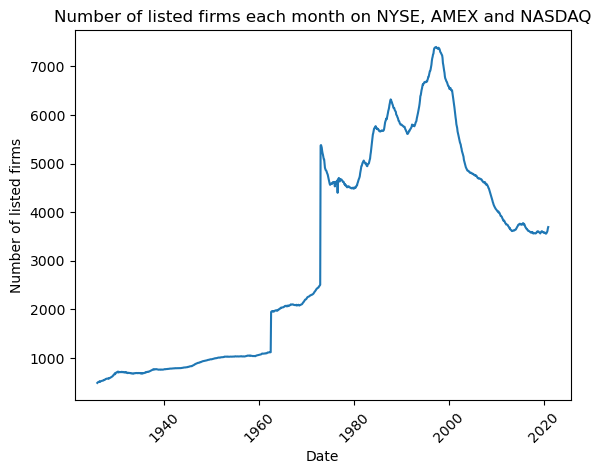

In [6]:
# Group by year and month
by_month = df.groupby(df['date'])['PERMNO'].nunique().reset_index()
by_month['date'] = pd.to_datetime(by_month['date'])

# Create plot of number of firms listed each month
plt.plot(by_month['date'], by_month['PERMNO'])
plt.title('Number of listed firms each month on NYSE, AMEX and NASDAQ')
plt.xlabel('Date')
plt.ylabel('Number of listed firms')
plt.xticks(rotation=45)
plt.show()

## Problem 2

### Part A

In [7]:
sortdf = df.copy()
sortdf['rank'] = sortdf.groupby('date')['MV'].rank(pct=True)

# Label decile portfolios
sortdf['decile'] = np.ceil(sortdf['rank']*10)

# Calculate weights
# Introduces Nans because some rows do not have BM_decile
sortdf = sortdf.groupby(['date', 'decile'], group_keys=False).apply(calc_weights)

# Move weights and deciles forward one month
# We form portfolios at the end of this month, and then earn returns over
# the next month.
sortdf['decile_lag'] = sortdf.groupby('PERMNO')['decile'].shift(1)
sortdf['weights_val_lag'] = sortdf.groupby('PERMNO')['weights_val'].shift(1)
sortdf['weights_eq_lag'] = sortdf.groupby('PERMNO')['weights_eq'].shift(1)

sortdf = sortdf.drop(['rank', 'decile', 'weights_eq', 'TMV', 'weights_val'], axis=1)
sortdf

,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT,MV,decile_lag,weights_val_lag,weights_eq_lag
2,10000,1986-02,10,3,NA,-0.257143,3680.0,-1.196000e+04,NaN,NaN,NaN
3,10000,1986-03,10,3,NA,0.365385,3680.0,-1.633000e+04,2.0,0.002569,0.001764
4,10000,1986-04,10,3,NA,-0.098592,3793.0,-1.517200e+04,1.0,0.000633,0.001764
5,10000,1986-05,10,3,NA,-0.222656,3793.0,-1.179388e+04,1.0,0.000537,0.001761
6,10000,1986-06,10,3,NA,-0.005025,3793.0,-1.173459e+04,2.0,0.002190,0.001757
...,...,...,...,...,...,...,...,...,...,...,...
4705164,93436,2020-08,11,3,498.32001,0.741452,931809.0,4.643391e+08,10.0,0.009848,0.002809
4705165,93436,2020-09,11,3,429.01001,-0.139087,948000.0,4.067015e+08,10.0,0.015858,0.002793
4705166,93436,2020-10,11,3,388.04001,-0.095499,947901.0,3.678235e+08,10.0,0.014437,0.002778
4705167,93436,2020-11,11,3,567.59998,0.462736,947901.0,5.380286e+08,10.0,0.013411,0.002762


### Part B

decile_lag
1.0     1.416475
2.0     1.376012
3.0     1.385190
4.0     1.370267
5.0     1.345155
6.0     1.414903
7.0     1.206844
8.0     1.138195
9.0     1.099439
10.0    0.950268
dtype: float64

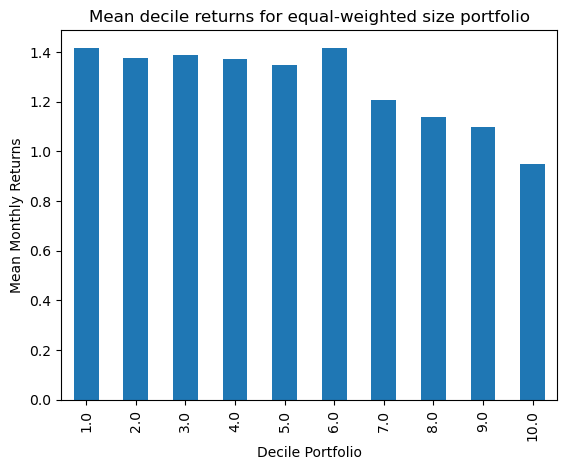

decile_lag
1.0    -1.081856
2.0     1.353561
3.0     1.648992
4.0     1.151185
5.0     1.514830
6.0     4.942626
7.0     1.208720
8.0     1.135251
9.0     1.099974
10.0    0.921144
dtype: float64

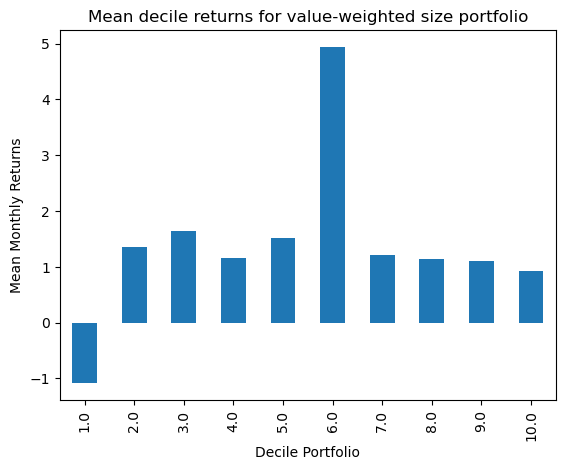

In [8]:
eqports, valports = part_b(sortdf)

display(eqports.mean(numeric_only=True))
graph_deciles(eqports, 'Mean decile returns for equal-weighted size portfolio')

display(valports.mean(numeric_only=True))
graph_deciles(valports, 'Mean decile returns for value-weighted size portfolio')

The mean monthly returns appear to be monotonic in both the equal-weighted and value-weighted portfolios.

### Part C

In [9]:
analyze(eqports, 'Equal-weighted Size', 'RET')
analyze(valports, 'Value-weighted Size', 'RET')

Equal-weighted Size monthly returns have mean 0.4662073488692189, vol 4.752491162830198, and Sharpe 0.09809746781129912
Value-weighted Size monthly returns have mean -2.002999518394746, vol 42.135310260594544, and Sharpe -0.0475373150454282


### Part D

In [10]:
print('Equal-Weighted Size:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(eqports, 'RET', ff3)

print('\n\n\n\nValue-Weighted Size:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(valports, 'RET', ff3)

Equal-Weighted Size:
----------------------------------------------------------------------------------
CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     7.649
Date:                Fri, 19 Apr 2024   Prob (F-statistic):            0.00577
Time:                        15:03:31   Log-Likelihood:                -3380.3
No. Observations:                1134   AIC:                             6765.
Df Residuals:                    1132   BIC:                             6775.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

For both the equal-weighted and value-weighted portfolios, the alphas for the CAPM model are greater than that of the FF3 model. In the equal-weighted portfolio, the alpha for the CAPM model is 1.43 while the alpha for the FF3 model is 0.89. In the value-weighted portfolio, the alpha for the CAPM model is 0.85 while the alpha for the FF3 model is 0.38.

capm alpha higher than ff3
equal weighted higher alpha, bc higher weight to small stocks
### Part E

In [11]:
post_FF = eqports[eqports['date'] > '1992-00'].copy()
analyze(post_FF, 'Equal-weighted Size', 'RET')
estimate_capm_and_ff3(post_FF, 'RET', ff3)

Equal-weighted Size monthly returns have mean 1.2606555812152573, vol 6.0693586996530415, and Sharpe 0.2077082017392255
CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7624
Date:                Fri, 19 Apr 2024   Prob (F-statistic):              0.383
Time:                        15:03:31   Log-Likelihood:                -1120.8
No. Observations:                 348   AIC:                             2246.
Df Residuals:                     346   BIC:                             2253.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

In [12]:
post_FF = eqports[eqports['date'] > '2002-00'].copy()
analyze(post_FF, 'Equal-weighted Size', 'RET')
estimate_capm_and_ff3(post_FF, 'RET', ff3)

Equal-weighted Size monthly returns have mean 1.143056778405078, vol 5.4225974688813, and Sharpe 0.2107950636138394
CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.119
Date:                Fri, 19 Apr 2024   Prob (F-statistic):              0.291
Time:                        15:03:31   Log-Likelihood:                -708.62
No. Observations:                 228   AIC:                             1421.
Df Residuals:                     226   BIC:                             1428.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------

Yes, the size strategy still works. As we can see from the results of the analysis, since 
the Fama French 1992 paper was published, the alpha is still high for a 
equal-weighted long-short small-minus-big portfolio in both the CAPM and FF3
models. Additionally, the graphs of the mean monthly returns of each decile 
since the publication of the 1992 Fama French paper show that the 1st decile's 
returns are still larger than that of the 10th decile. So, the size portfolio
still works.

We can see that the same still holds for the size factor since the Dot-Com
Bubble burst (post-2002). However, as we can see from the graph, although the 
1st decile's mean monthly returns are still higher than the 10th decile's 
returns, the difference is much smaller than before. So, while size still works,
it definitely does not work as well as in the past.

## Problem 3
### Part A

In [13]:
# Calculate cumulative returns from month t-11 to month t-1
cum_rets = df.groupby('PERMNO')['RET'].rolling(window=11, min_periods=11).apply(lambda x: np.prod(1+x)-1).shift(1)
idx = cum_rets.index.get_level_values(1)
cum_rets = pd.Series(cum_rets.values, index=idx).rename('11M_RET')
cum_rets

2               NaN
3               NaN
4               NaN
5               NaN
6               NaN
             ...   
4705164    5.341741
4705165    9.344169
4705166    5.811416
4705167    4.880464
4705168    5.784121
Name: 11M_RET, Length: 3563041, dtype: float64

In [14]:
# Merge 11 month rolling returns into df_merged
df_11m_rets = pd.merge(df, cum_rets, left_index=True, right_index=True)
assert(len(df_11m_rets) == len(df))
df_11m_rets = df_11m_rets.dropna(subset=['11M_RET'])
df_11m_rets

,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT,MV,11M_RET
13,10000,1987-01,10,3,NA,-0.212121,3893.0,-1.581531e+03,-0.882143
14,10000,1987-02,10,3,NA,0.000000,3893.0,-1.581531e+03,-0.875000
15,10000,1987-03,10,3,NA,-0.384615,3893.0,-9.732500e+02,-0.908451
16,10000,1987-04,10,3,NA,-0.062500,3893.0,-9.124413e+02,-0.937500
17,10000,1987-05,10,3,NA,-0.066667,3893.0,-8.515938e+02,-0.924623
...,...,...,...,...,...,...,...,...,...
4705164,93436,2020-08,11,3,498.32001,0.741452,931809.0,4.643391e+08,5.341741
4705165,93436,2020-09,11,3,429.01001,-0.139087,948000.0,4.067015e+08,9.344169
4705166,93436,2020-10,11,3,388.04001,-0.095499,947901.0,3.678235e+08,5.811416
4705167,93436,2020-11,11,3,567.59998,0.462736,947901.0,5.380286e+08,4.880464


In [15]:
# Add deciles
df_11m_rets['rank'] = df_11m_rets.groupby('date')['11M_RET'].rank(pct=True)
df_11m_rets['decile'] = np.ceil(df_11m_rets['rank']*10)

# Use calc_weights helper to get the equal- and value-weighted portfolios
df_weights = df_11m_rets.groupby(['date', 'decile'], group_keys=False).apply(calc_weights)
df_weights['decile_lag'] = df_weights.groupby('PERMNO')['decile'].shift(1)
df_weights['weights_val_lag'] = df_weights.groupby('PERMNO')['weights_val'].shift(1)
df_weights['weights_eq_lag'] = df_weights.groupby('PERMNO')['weights_eq'].shift(1)

# Process final portfolio weights
df_weights = df_weights.drop(['rank', 'decile', 'weights_eq', 'TMV', 'weights_val'], axis=1)
df_weights

,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT,MV,11M_RET,decile_lag,weights_val_lag,weights_eq_lag
13,10000,1987-01,10,3,NA,-0.212121,3893.0,-1.581531e+03,-0.882143,NaN,NaN,NaN
14,10000,1987-02,10,3,NA,0.000000,3893.0,-1.581531e+03,-0.875000,1.0,-0.000124,0.001942
15,10000,1987-03,10,3,NA,-0.384615,3893.0,-9.732500e+02,-0.908451,1.0,-0.000138,0.001946
16,10000,1987-04,10,3,NA,-0.062500,3893.0,-9.124413e+02,-0.937500,1.0,-0.000095,0.001931
17,10000,1987-05,10,3,NA,-0.066667,3893.0,-8.515938e+02,-0.924623,1.0,-0.000113,0.001919
...,...,...,...,...,...,...,...,...,...,...,...,...
4705164,93436,2020-08,11,3,498.32001,0.741452,931809.0,4.643391e+08,5.341741,10.0,0.064041,0.002924
4705165,93436,2020-09,11,3,429.01001,-0.139087,948000.0,4.067015e+08,9.344169,10.0,0.071555,0.002933
4705166,93436,2020-10,11,3,388.04001,-0.095499,947901.0,3.678235e+08,5.811416,10.0,0.057799,0.002933
4705167,93436,2020-11,11,3,567.59998,0.462736,947901.0,5.380286e+08,4.880464,10.0,0.060662,0.002924


### Part B

decile_lag
1.0     1.188416
2.0     1.056829
3.0     1.037597
4.0     1.184081
5.0     1.178271
6.0     1.315282
7.0     1.367015
8.0     1.466746
9.0     1.579702
10.0    1.779682
dtype: float64

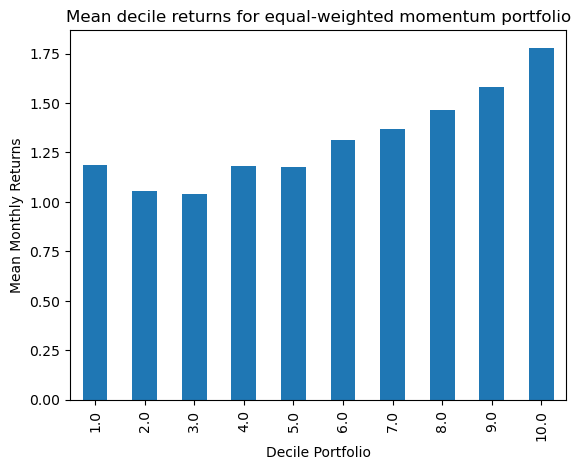

decile_lag
1.0     0.325233
2.0     0.478033
3.0     0.577681
4.0     0.899085
5.0     0.954930
6.0     0.916098
7.0     1.108987
8.0     1.173256
9.0     1.208418
10.0    1.414659
dtype: float64

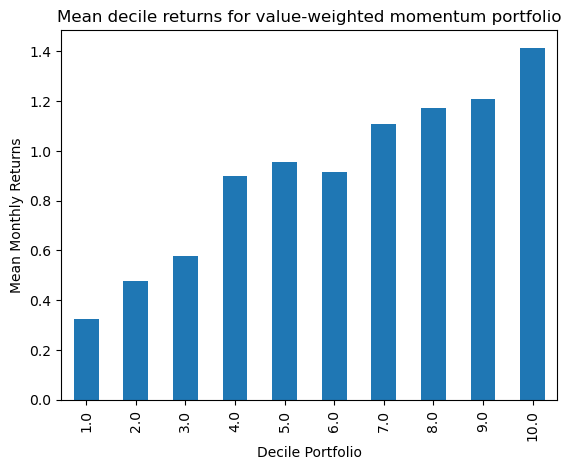

In [16]:
eq_decile_returns, val_decile_returns = part_b(df_weights)

display(eq_decile_returns.mean(numeric_only=True))
graph_deciles(eq_decile_returns, 'Mean decile returns for equal-weighted momentum portfolio')

display(val_decile_returns.mean(numeric_only=True))
graph_deciles(val_decile_returns, 'Mean decile returns for value-weighted momentum portfolio')

### Part C

In [17]:
analyze(eq_decile_returns, 'Equal-weighted Momentum', 'MOM', reverse=True)
analyze(val_decile_returns, 'Value-weighted Momentum', 'MOM', reverse=True)

Equal-weighted Momentum monthly returns have mean 0.5912655053927323, vol 8.271794705615111, and Sharpe 0.07147971225535442
Value-weighted Momentum monthly returns have mean 1.0894255050449222, vol 15.124614208303308, and Sharpe 0.07202996982540125


### Part D

In [18]:
print('Equal-Weighted Momentum:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(eq_decile_returns, 'MOM', ff3)
estimate_ff5(eq_decile_returns, 'MOM', ff5)

print('\n\n\n\nValue-Weighted Momentum:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(val_decile_returns, 'MOM', ff3)
estimate_ff5(val_decile_returns, 'MOM', ff5)

# Save momentum returns for part 4
eq_mom_returns = eq_decile_returns[['date', 'MOM']]
val_mom_returns = val_decile_returns[['date', 'MOM']]

Equal-Weighted Momentum:
----------------------------------------------------------------------------------
CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     110.6
Date:                Fri, 19 Apr 2024   Prob (F-statistic):           9.63e-25
Time:                        15:09:32   Log-Likelihood:                -3932.0
No. Observations:                1129   AIC:                             7868.
Df Residuals:                    1127   BIC:                             7878.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

The value-weighted momentum portfolios have far better alphas. Perhaps moving the market is a larger factor for the momentum strategy than the other strategies.

Under the CAPM model, the FF3 model, and the FF5 model, the alpha that the equal-weighted and value-weighted momentum strategies are generating is not statistically significant. However, the alpha is consistently smaller under the FF5 model, indicating that FF5 does a decent job pricing momentum.

### Part E
We find it likely that the positive momentum alphas are indicative of some unpriced risk. For one, since the momentum papers have been out for a while and this strategy is relatively easy to implement, it stands to reason that the market has priced momentum into the equation already.

Second, it is not hard to imagine that a momentum strategy could face extreme risk: if the portfolio is rebalanced monthly and happens to buy into hot stocks at the start of the month, there is no guarantee that this momentum will carry through the whole month, as just one example.

## Problem 4
### Part A
Notes: Losing ~3000 (<0.1% of) rows since FF website starts July 1926, Professor Sinclair's data starts January 1926. We also assume that once data starts for a given stock, then it continues to be present every month until it stops.

In [19]:
# Merge ff3 data and edit columns
df_merged = pd.merge(df, ff3, how='inner', on=['date'])
df_merged['Ret-RF'] = df_merged['RET'] - df_merged['RF']
df_merged = df_merged.drop(['SHRCD', 'EXCHCD', 'PRC', 'SHROUT', 'SMB', 'HML', 'RF'], axis=1)
df_merged

,PERMNO,date,RET,MV,Mkt-RF,Ret-RF
0,10000,1986-02,-0.257143,-1.196000e+04,7.13,-0.787143
1,10001,1986-02,0.020408,-6.156250e+03,7.13,-0.509592
2,10002,1986-02,0.139785,-1.556875e+04,7.13,-0.390215
3,10003,1986-02,0.011364,-4.227500e+04,7.13,-0.518636
4,10005,1986-02,-0.333333,-1.163750e+03,7.13,-0.863333
...,...,...,...,...,...,...
3560037,93422,2020-12,0.484472,5.806170e+05,4.63,0.474472
3560038,93423,2020-12,0.109665,2.897716e+06,4.63,0.099665
3560039,93426,2020-12,0.076239,3.951370e+05,4.63,0.066239
3560040,93434,2020-12,0.122605,1.001035e+05,4.63,0.112605


In [20]:
# Applies the rolling ols and returns the betas where there are enough months
# or np.NaN where there are not enough months
def rolling_ols(group):
    dates = np.array(group['date'])
    
    if len(group) >= 36:
        y = group['Ret-RF']
        x = sm.add_constant(group['Mkt-RF'])
        model = RollingOLS(y, x, window=36)
        
        beta_vals = np.array(model.fit().params[['Mkt-RF']].values)
        return np.column_stack((dates, beta_vals))
    else:
        return np.column_stack((dates, np.full(len(group), np.nan)))

# Get the market beta for stock i from time t-36 to time t
beta_i_t = df_merged.groupby('PERMNO').apply(rolling_ols)
beta_i_t = pd.DataFrame(beta_i_t, columns=['beta'])
beta_i_t = beta_i_t.explode('beta')
beta_i_t[['date', 'beta']] = beta_i_t['beta'].apply(lambda el: pd.Series(el))
beta_i_t

,beta,date
PERMNO,,
10000,NaN,1986-02
10000,NaN,1986-03
10000,NaN,1986-04
10000,NaN,1986-05
10000,NaN,1986-06
...,...,...
93436,0.021938,2020-08
93436,0.022043,2020-09
93436,0.022111,2020-10


In [21]:
# Merge betas into df and drop NaN betas
df_betas = pd.merge(df_merged, beta_i_t, how='inner', on=['PERMNO', 'date'])
assert(len(df_betas) == len(df_merged))
df_betas = df_betas.dropna()
df_betas

,PERMNO,date,RET,MV,Mkt-RF,Ret-RF,beta
211408,10001,1989-01,0.019608,6.487000e+03,6.10,-0.530392,0.003084
211409,10002,1989-01,0.059701,-1.042812e+04,6.10,-0.490299,0.007428
211410,10003,1989-01,-0.039474,4.004050e+04,6.10,-0.589474,0.009937
211411,10005,1989-01,0.000000,-7.852500e+02,6.10,-0.550000,0.012275
211412,10009,1989-01,-0.011111,-1.035100e+04,6.10,-0.561111,0.009761
...,...,...,...,...,...,...,...
3560037,93422,2020-12,0.484472,5.806170e+05,4.63,0.474472,0.056771
3560038,93423,2020-12,0.109665,2.897716e+06,4.63,0.099665,0.029131
3560039,93426,2020-12,0.076239,3.951370e+05,4.63,0.066239,0.018964
3560040,93434,2020-12,0.122605,1.001035e+05,4.63,0.112605,0.012075


In [22]:
# Add deciles
df_betas['rank'] = df_betas.groupby('date')['beta'].rank(pct=True)
df_betas['decile'] = np.ceil(df_betas['rank']*10)

# Use calc_weights helper to get the equal- and value-weighted portfolios
df_weights = df_betas.groupby(['date', 'decile'], group_keys=False).apply(calc_weights)
df_weights['decile_lag'] = df_weights.groupby('PERMNO')['decile'].shift(1)
df_weights['weights_val_lag'] = df_weights.groupby('PERMNO')['weights_val'].shift(1)
df_weights['weights_eq_lag'] = df_weights.groupby('PERMNO')['weights_eq'].shift(1)

# Process final portfolio weights
df_weights = df_weights.drop(['rank', 'decile', 'weights_eq', 'TMV', 'weights_val'], axis=1)
df_weights

,PERMNO,date,RET,MV,Mkt-RF,Ret-RF,beta,decile_lag,weights_val_lag,weights_eq_lag
211408,10001,1989-01,0.019608,6.487000e+03,6.10,-0.530392,0.003084,NaN,NaN,NaN
211409,10002,1989-01,0.059701,-1.042812e+04,6.10,-0.490299,0.007428,NaN,NaN,NaN
211410,10003,1989-01,-0.039474,4.004050e+04,6.10,-0.589474,0.009937,NaN,NaN,NaN
211411,10005,1989-01,0.000000,-7.852500e+02,6.10,-0.550000,0.012275,NaN,NaN,NaN
211412,10009,1989-01,-0.011111,-1.035100e+04,6.10,-0.561111,0.009761,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3560037,93422,2020-12,0.484472,5.806170e+05,4.63,0.474472,0.056771,10.0,0.000783,0.003333
3560038,93423,2020-12,0.109665,2.897716e+06,4.63,0.099665,0.029131,10.0,0.005243,0.003333
3560039,93426,2020-12,0.076239,3.951370e+05,4.63,0.066239,0.018964,7.0,0.000173,0.003333
3560040,93434,2020-12,0.122605,1.001035e+05,4.63,0.112605,0.012075,3.0,0.000015,0.003344


### Part B

decile_lag
1.0     1.208187
2.0     1.224995
3.0     1.301618
4.0     1.364806
5.0     1.384438
6.0     1.403992
7.0     1.426910
8.0     1.512215
9.0     1.459779
10.0    1.431196
dtype: float64

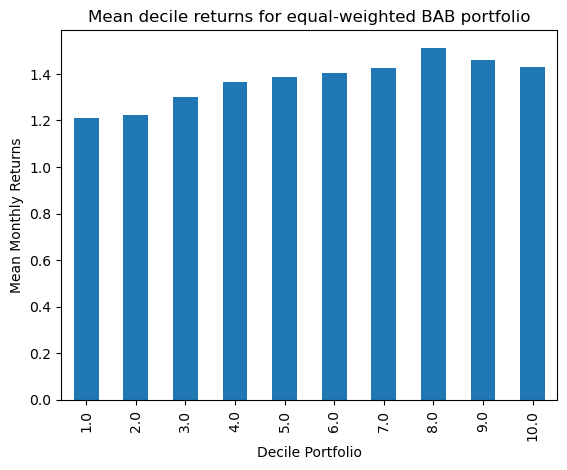

decile_lag
1.0     1.004125
2.0     0.832402
3.0     0.951193
4.0     1.146122
5.0     1.110693
6.0     0.977431
7.0     1.069576
8.0     1.108654
9.0     1.138102
10.0    1.505888
dtype: float64

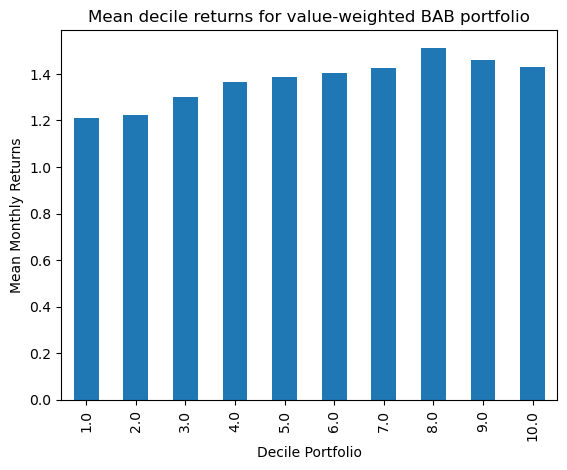

In [23]:
eq_decile_returns, val_decile_returns = part_b(df_weights)

display(eq_decile_returns.mean(numeric_only=True))
graph_deciles(eq_decile_returns, 'Mean decile returns for equal-weighted BAB portfolio')

display(val_decile_returns.mean(numeric_only=True))
graph_deciles(eq_decile_returns, 'Mean decile returns for value-weighted BAB portfolio')

Neither the mean equal-weighted BAB portfolio returns nor the mean value-weighted BAB portfolio returns are perfectly monotonic, though there is a strong general upward trend as the beta decile increases. This makes sense, as the market has gone up on average from 1926, stocks with higher beta would have higher returns on average.

### Part C

In [24]:
analyze(eq_decile_returns, 'Equal-weighted BAB', 'BAB')
analyze(val_decile_returns, 'Value-weighted BAB', 'BAB')

Equal-weighted BAB monthly returns have mean -0.2230094542418828, vol 7.564635739619426, and Sharpe -0.029480527803061447
Value-weighted BAB monthly returns have mean -0.5017628543158043, vol 21.97712115297991, and Sharpe -0.022831145663851856


### Part D

In [25]:
print('Equal-Weighted Betting-Against-Beta:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(eq_decile_returns, 'BAB', ff3)
estimate_ff5(eq_decile_returns, 'BAB', ff5, add_momentum=True, mom_rets=eq_mom_returns)

print('\n\n\n\nValue-Weighted Betting-Against-Beta:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(val_decile_returns, 'BAB', ff3)
estimate_ff5(val_decile_returns, 'BAB', ff5, add_momentum=True, mom_rets=val_mom_returns)

Equal-Weighted Betting-Against-Beta:
----------------------------------------------------------------------------------
CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     1264.
Date:                Fri, 19 Apr 2024   Prob (F-statistic):          9.18e-185
Time:                        15:18:32   Log-Likelihood:                -3356.5
No. Observations:                1098   AIC:                             6717.
Df Residuals:                    1096   BIC:                             6727.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

### Part E
We are taking a long position in low-beta stocks and a short position in high-beta stocks. Therefore, on average, if the market goes up and the high beta stocks perform comparatively better, we will lose money.

Consider reducing the correlation of the assets with each other (not just to the market)